In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import ompy as om
import uproot as up
import watermark
%load_ext watermark

In [3]:
%watermark -n -u -v -iv -w

Last updated: Wed Dec 21 2022

Python implementation: CPython
Python version       : 3.10.2
IPython version      : 8.5.0

ompy      : 1.1.0.dev0+740d287
uproot    : 4.3.7
matplotlib: 3.6.1
watermark : 2.3.1
numpy     : 1.23.4

Watermark: 2.3.1



In [4]:
from typing import Iterable, Optional
def Histogram1D(values : Iterable[float], **kwargs) -> om.Vector:
    counts, bin_edges = np.histogram(values, **kwargs)
    return om.Vector(values=counts, E=[0.5*(bin_edges[i+1]+bin_edges[i]) for i in range(len(bin_edges)-1)])

def Histogram2D(x : Iterable[float],
                y : Iterable[float], **kwargs) -> om.Matrix:
    counts, xedges, yedges = np.histogram2d(x, y, **kwargs)
    return om.Matrix(values=counts.T,
                  Eg=np.array([0.5*(xedges[i+1]+xedges[i]) for i in range(len(xedges)-1)]),
                  Ex=np.array([0.5*(yedges[i+1]+yedges[i]) for i in range(len(yedges)-1)])) 

# Analysis of the simulated AFRODITE data
In this notebook we will read ROOT tuples and analyze the data in order to write spectra to disk. The spectras will be analyzed in other scripts

## Read and analyze a single simulation file
In this cell we will define the logic needed to read a single file, create the spectra

In [5]:
def get_energy(path):
    """ Extract the energy from the filename."""
    from pathlib import Path
    name = Path(path).name
    energy = int(name[name.find("_")+1:name.find("keV")])
    return energy
    
def get_ocl_labr_events(filename):
    tree = up.open(f"{filename}:DataTreeSim")
    labr = []
    for name in [f'OCLLABR_Energy{i}' for i in range(6)]:
        labr.append(file['DataTreeSim'][name].array(library="np"))
    labr = np.concatenate(labr)
    return tree.num_entries, Histogram1D(labr[labr > 0], range=[-0.5, get_energy(filename)+100.5], bins=get_energy(filename)+101)

def fit_peak(spectra: om.Vector, peak_energy: float):
    """ Fit a peak with a linear background
    """
    pidx = spectra.index(peak_energy)
    en_pk = spectra.E[pidx]
    counts_pk = spectra.values[pidx]
    en_bg = np.concatenate((spectra.E[:pidx], spectra.E[pidx+1:]))
    counts_bg = np.concatenate((spectra.values[:pidx], spectra.values[pidx+1:]))
    
    p = np.polyfit(en_bg, counts_bg, 1)
    return counts_pk - np.polyval(p, en_pk)

def sigma_labr(Eg):
    a0, a1, a2 = 60.64, 0.458, 2.6555e-4
    return np.sqrt(a0 + a1*Eg + a2*Eg**2)/(2*np.sqrt(2*np.log(2)))

def gauss_smoothing(spectra: om.Vector):
    bin_size = spectra.E[1] - spectra.E[0]
    sigma = 25 * bin_size * np.ones(len(spectra)) #sigma_labr(spectra.E) * 1.5
    smoothed = spectra.copy()
    for i in range(len(smoothed)):
        weight = np.exp(-0.5*(bin_size*(i-np.arange(len(spectra)))/sigma[i])**2) / (np.sqrt(2*np.pi) * sigma[i])
        smoothed.values[i] = np.sum(spectra.values * weight) 
    return smoothed

def analyze_spectrum(energy, num_entries, histogram):
    fe_idx = histogram.index(energy)
    
    # Number of full energy peaks
    nFE = histogram.values[fe_idx]
    compton = histogram.copy()
    compton.values[fe_idx] -= nFE
    nSE = 0
    nDE = 0
    n511 = 0
    if energy > 1022:
        nSE = fit_peak(histogram.cut(energy-511-5, energy-511+5, inplace=False),
                       energy-511)
        nDE = fit_peak(histogram.cut(energy-1022-5, energy-1022+5, inplace=False),
                       energy - 1022)
        n511 = fit_peak(histogram.cut(511-5, 511+5, inplace=False), 511)
        compton.values[compton.index(energy-511)] -= nSE
        compton.values[compton.index(energy-1022)] -= nDE
        compton.values[compton.index(511)] -= n511
        compton = gauss_smoothing(compton)
        compton.values[compton.values < 1] = 0
    return {'Eg': energy, 'nFE': nFE, 'nSE': nSE, 'nDE': nDE, 'n511': n511}, compton

In [6]:
def analyze_energy(res_folder, read_folder):
    from pathlib import Path
    from tqdm.notebook import tqdm 
    files = [str(p) for p in sorted(Path(read_folder).glob("energy_*.root"))]
    resp = {'Eg': [], 'nFE': [], 'nSE': [], 'nDE': [], 'n511': []}
    for file in tqdm(files, total=len(files)):
        r, c = analyze_spectrum(get_energy(file), *get_ocl_labr_events(file))
        for key in resp:
            resp[key].append(r[key])
        c.save(Path(res_folder)/f"cmp{get_energy(file)}", filetype="mama", _assert=False)
        
analyze_energy("./ocl", "/Volumes/PR271/afrodite6LaBr3")

0it [00:00, ?it/s]

(<Figure size 640x480 with 1 Axes>, <AxesSubplot:xlabel='Energy [keV]'>)

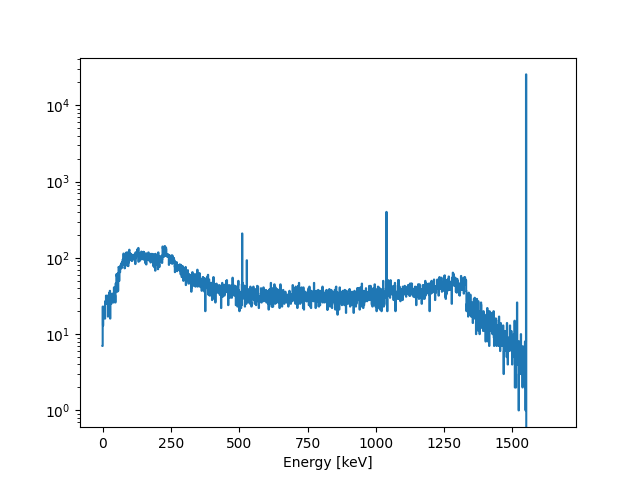

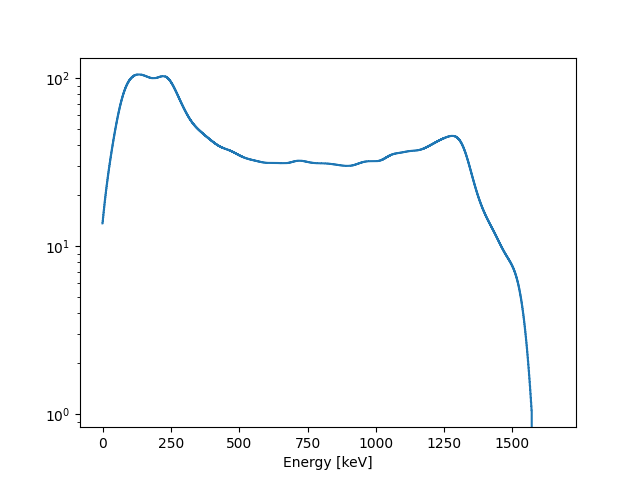

In [189]:
entries.plot(kind='step', scale='log')
compton.plot(kind='step', scale='log')

In [7]:
# Count the number of events with exactly 1550 keV
v = Histogram1D(labr, range=[0, 2000], bins=2000)
v.plot(kind='step', scale='log')

NameError: name 'labr' is not defined

In [77]:

r = fit_peak(v.cut(1550 - 511 - 20, 1550 - 511 + 20, inplace=False), 1550-511)
print(r)

358.575


ValueError: Can only convert xarray dataarray, xarray dataset, dict, netcdf filename, numpy array, pystan fit, pymc3 trace, emcee fit, pyro mcmc fit, numpyro mcmc fit, cmdstan fit csv filename, cmdstanpy fit to InferenceData, not float64

(<Figure size 640x480 with 1 Axes>, <AxesSubplot:xlabel='Energy [keV]'>)

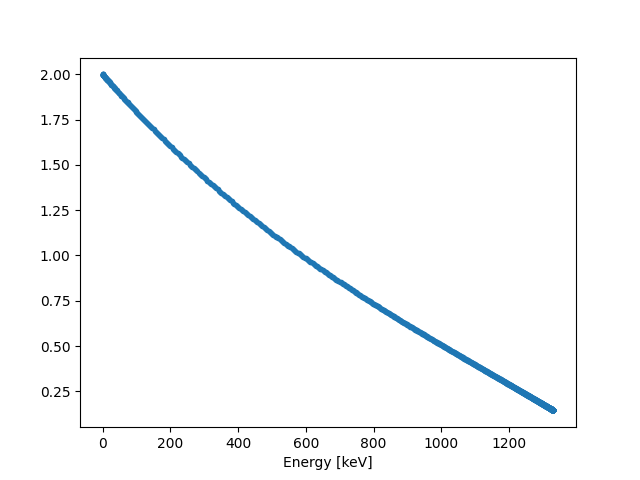

In [69]:
def compton_shape(theta, Eg):
    # Eg: Initial photon energy
    # Ed: Energy deposited
    # Eprime: Energy after Compton scattering
    # Return: Relative probability of depositing energy Ed
    eps = Eg/0.511
    nu = 1/(1 + eps*(1-np.cos(theta)))
    return (nu + 1/nu + np.sin(theta)**2)*nu**2

theta = np.linspace(0, np.pi, 1001)
Eprime = 1550 /(1 + (1.550/0.511)*(1-np.cos(theta)))
Ed = 1550 - Eprime
om.Vector(E=Ed, values=compton_shape(theta, 1550/1e3)).plot()